## Neural Style Transfer - Keras

In this notebook, we will explore and experiment with style transfer. Let us look at how to effectively transfer the texture of real world objects to a content image.

We will particularly explore how tiling style images has an impact on the final generated image and how effective that is in transferring the texture of real world objects.

## Imports

In [1]:
from __future__ import division,print_function
from PIL import Image
import gc,re

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Input, LSTM, GRU, Embedding, Convolution1D, MaxPooling1D, MaxPool1D
from keras.optimizers import Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from importlib import reload
from keras import backend as K
from keras.datasets import imdb

np.random.seed(7)

from keras.preprocessing.image import load_img, img_to_array

import bcolz
from IPython.display import FileLink
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

from scipy.optimize import fmin_l_bfgs_b
from keras import metrics
from scipy.misc import imsave
import imageio

%matplotlib inline

Using TensorFlow backend.


In the cell below, I am forcing Keras to use the 'channels_last' image data format since my backend is tensorflow. This would be set to 'channels_first' for Theano backend

In [2]:
K.set_image_data_format("channels_last")

In [3]:
PATH = 'data/imagenet_sample/'
RESULTS = PATH+'results_3/'

if not os.path.exists(RESULTS):
    print("Creating third results directory ... ")
    os.mkdir(RESULTS)

In [4]:
def preprocess_image(img):
    img = img_to_array(img)
    
    #Preprocessing for a grayscale image - (img_height, img_width, 1) to (img_height, img_width,3)
    if img.shape[2] == 1:
        img = img.reshape(img.shape[0], img.shape[1])
        img = gray2rgb(img)
    
    #convert (img_height, img_width, n_channels) to (1,img_height, img_width, n_channels)
    img = np.expand_dims(img, axis=0) # VGG expects images in batches, so we create a batch of 1 here
    img = preprocess_input(img)
    return img

In [5]:
def depreprocess_image(x, shape):

    x = x.reshape(shape)
    x = x + [123.68, 116.779, 103.939] #add the mean of the ImageNet dataset.
    # 'BGR'->'RGB'
    x = x[:, :,:, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x
    

In [6]:
class Evaluator(object):
    def __init__(self, fn, shape):
        self.fn = fn
        self.shape = shape
        
    def get_loss(self, x):
        x = x.reshape(self.shape)
        output = self.fn([x])
        loss = output[0].astype('float64')
        self.grads = np.array(output[1:])
        return loss
    
    def get_grads(self, x):
        return self.grads.flatten().astype('float64')


In [7]:
def solver(eval_obj, iters, x, shape, target = 'content'):
    
    for i in range(iters):
        print("Iteration : " + str(i))
        x, min_value, info = fmin_l_bfgs_b(eval_obj.get_loss, x.flatten(), \
                                           fprime=eval_obj.get_grads, maxfun=20)
        
        x = np.clip(x, -127,127)
        print(" Loss at iteration "+str(i) + " is : "+str(min_value))
        
        # Let us save how the random noise image looks life after each transformation
        BASE_STRING = 'res_at_iteration_'
        NAME = BASE_STRING + target + '_'
        fname = RESULTS+NAME+ str(i) +'.png' 
        imageio.imwrite(fname, depreprocess_image(x.copy(), shape)[0])
    return x

In [8]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)

In [9]:
from IPython.display import HTML
from matplotlib import animation,rc

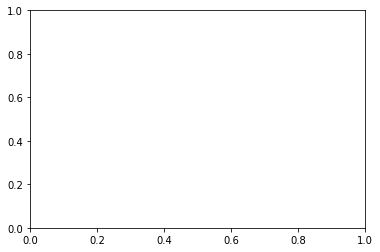

In [10]:
fig, ax = plt.subplots()


In [11]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x,(2,0,1)))
    gm = K.dot(features, K.transpose(features))
    gm_normalized = gm / (x.get_shape().num_elements()) # divide by the total elements in that tensor
    return gm_normalized

In [12]:
def style_loss(x,y):
    return metrics.mse(gram_matrix(x), gram_matrix(y))

## Tiling Style Images Exploration

In the earlier example that we looked at, for the content image transformation, we only took a single conv layer output. Let us now try an example with multiple conv layer output for both content and style image.

In [13]:
IMG = 'dicaprio.jpg'
new_content_image = Image.open(PATH+IMG)

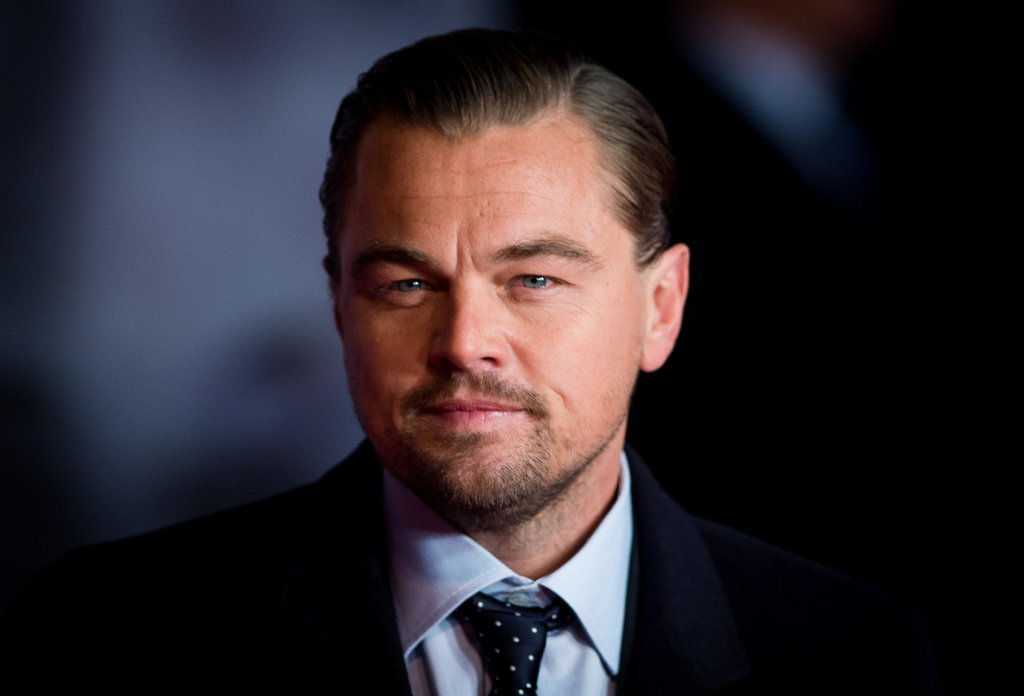

In [14]:
new_content_image

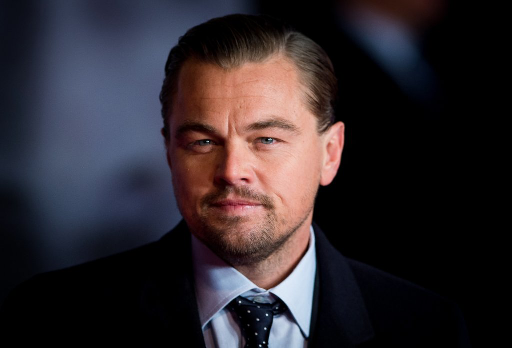

In [15]:
new_content_image = new_content_image.resize(np.divide(new_content_image.size,2).astype('int32'));new_content_image

### Untiled Style Image 

In [173]:
#STYLE_NEW = 'n_single.jpeg'
STYLE_NEW = 'n_tile.jpg'

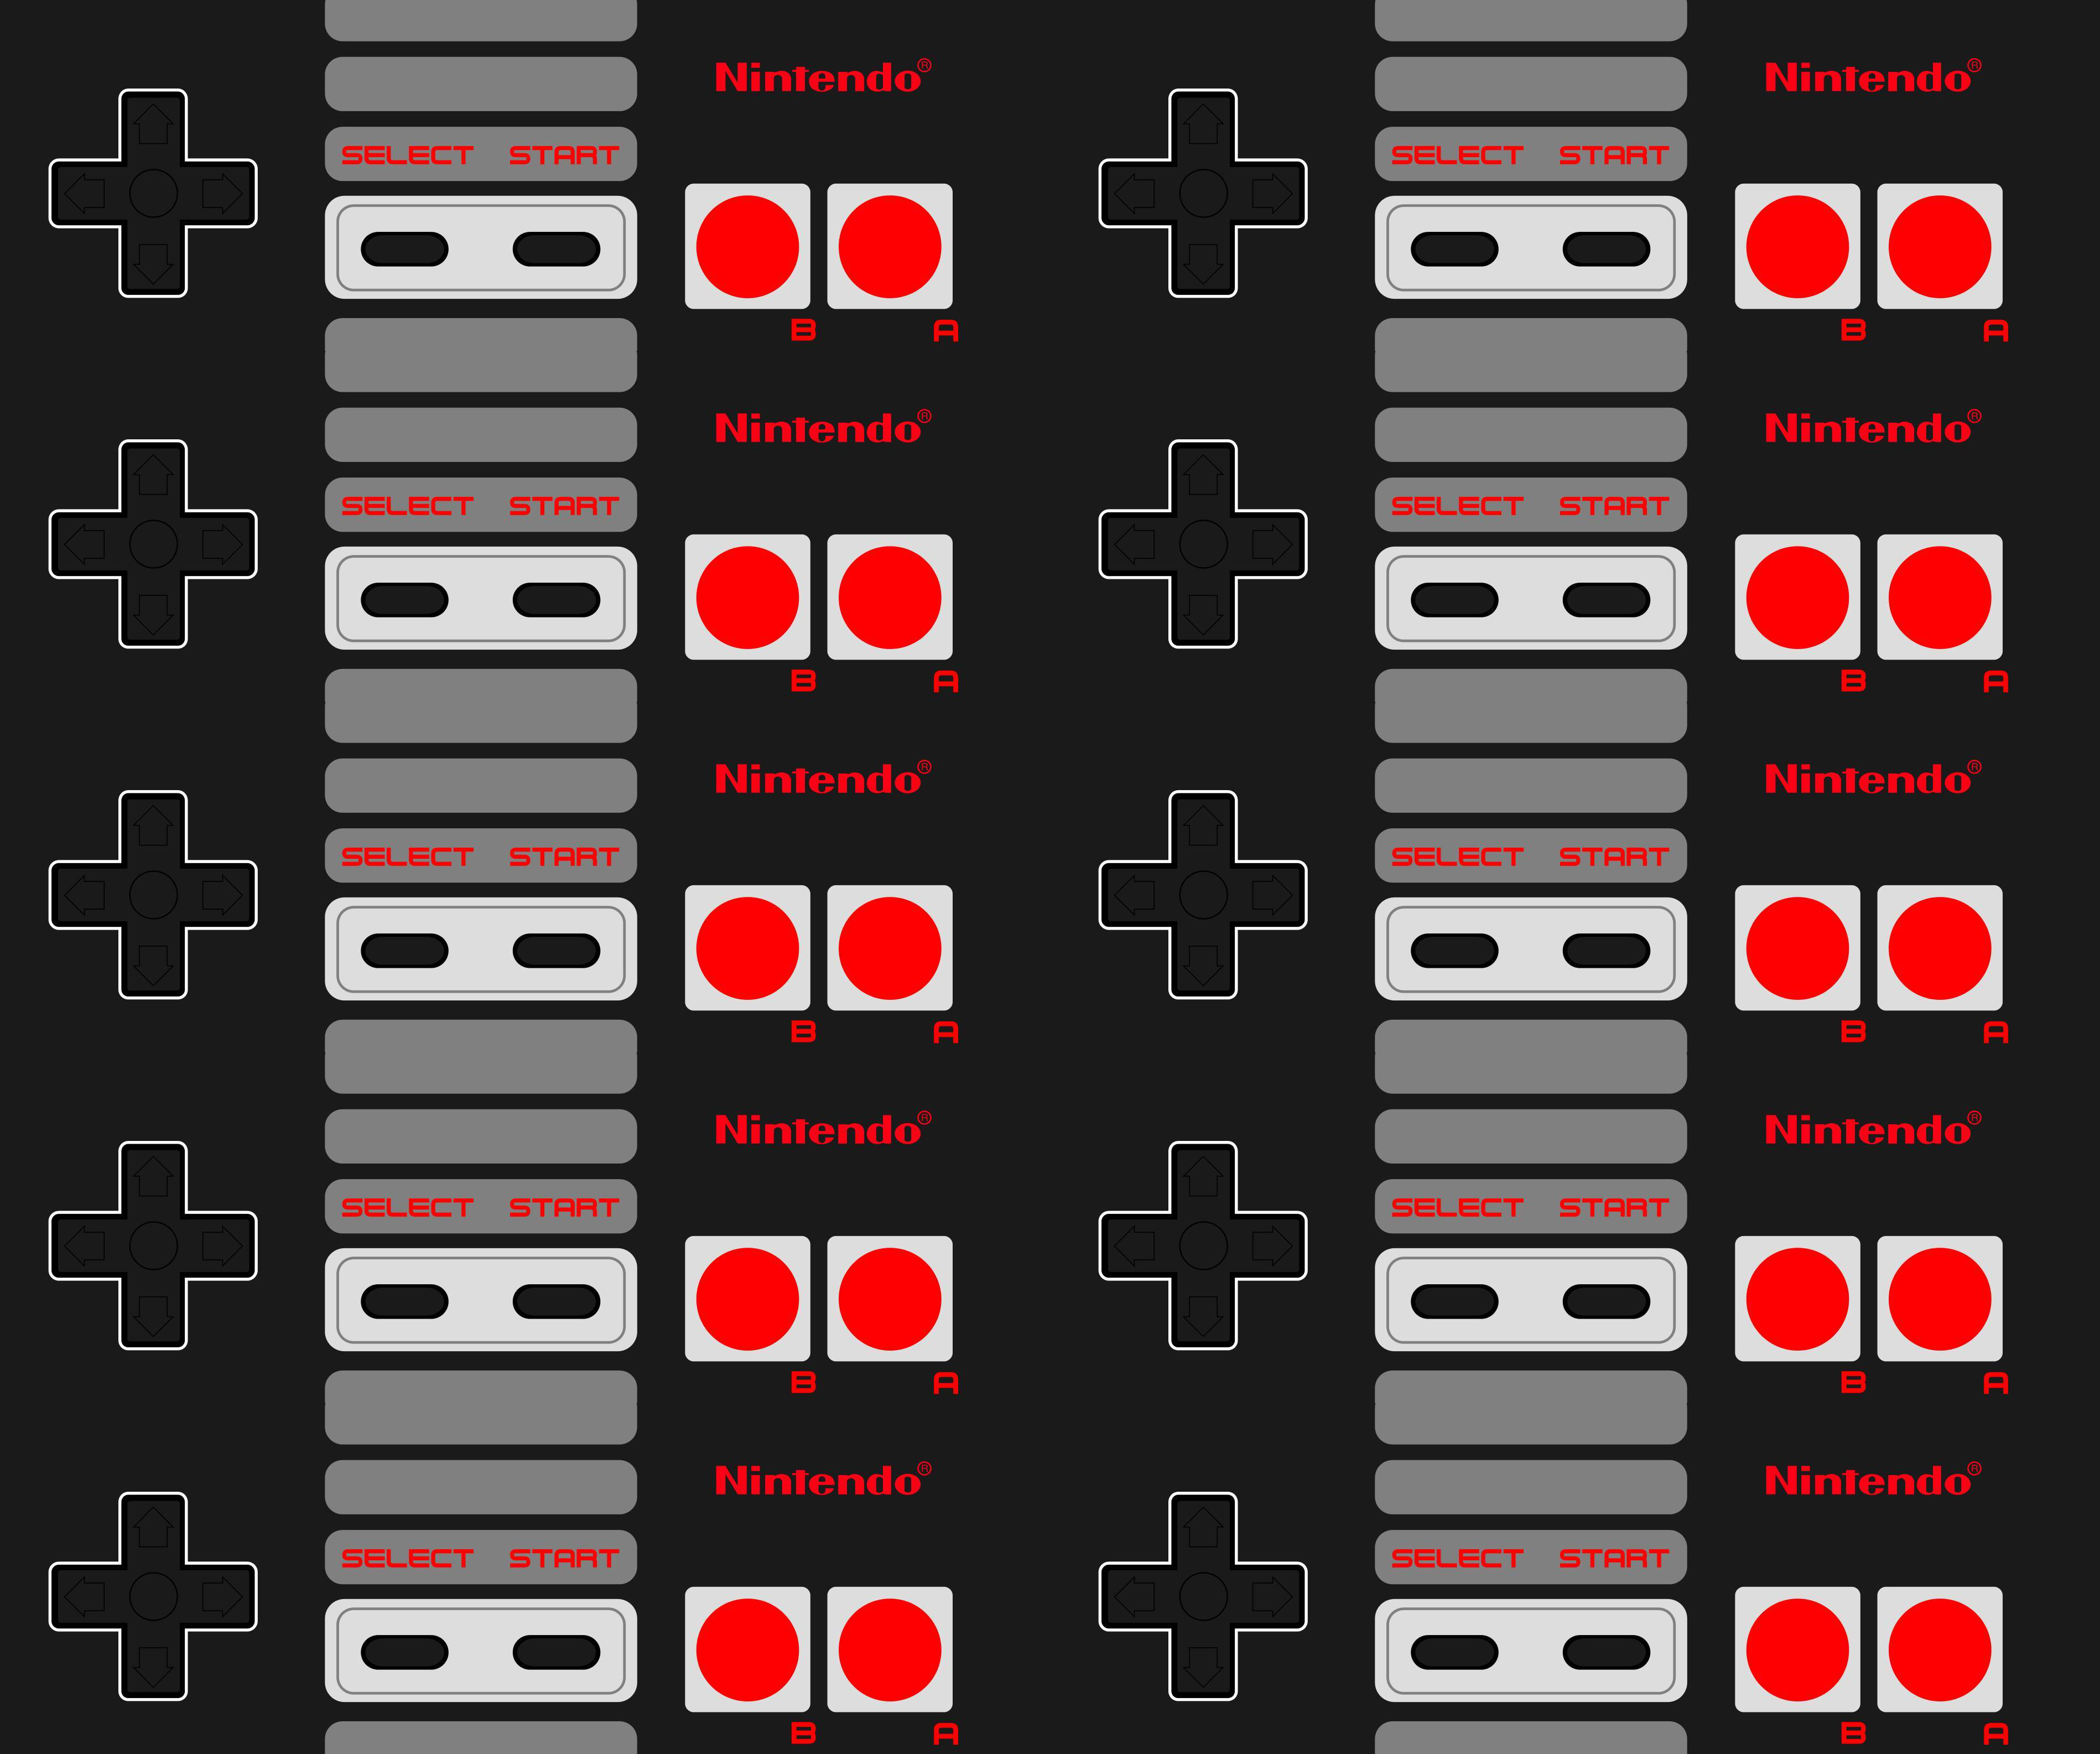

In [49]:
new_style_image = Image.open(PATH+STYLE_NEW);new_style_image

In [50]:
new_content_arr = preprocess_image(new_content_image)

In [51]:
new_content_shape = new_content_arr.shape
new_content_shape

(1, 348, 512, 3)

Let us now resize the style image to be the same as our content image.

In [52]:
new_style_image = new_style_image.resize((new_content_shape[2], new_content_shape[1]))

This was our normal style image

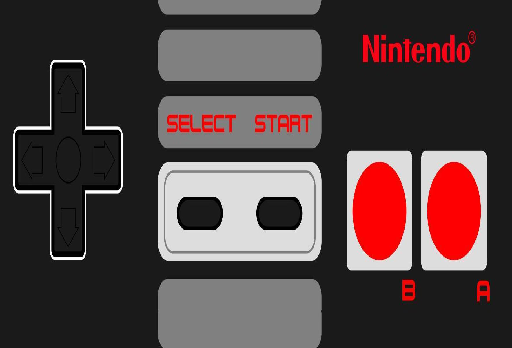

In [21]:
new_style_image

This is our tiled style image

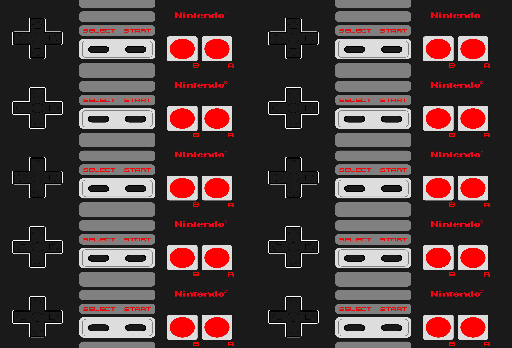

In [54]:
new_style_image

In [55]:
new_style_arr = preprocess_image(new_style_image)
new_style_shape = new_style_arr.shape
new_style_shape

(1, 348, 512, 3)

In [56]:
assert(new_style_shape == new_content_shape)

We need to get the VGG model again since the input shape has changed now.

In [57]:
base_vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=new_style_shape[1:])
base_vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 348, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 348, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 348, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 174, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 174, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 174, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 87, 128, 128)      0         
__________

In [58]:
output_dict = {layer.name : layer.output for layer in base_vgg_model.layers}

In [59]:
output_layers = []
for i in range(1,6):
    if i ==1 or i ==2:
         layer_name = 'block'+str(i)+'_conv2'
    else:
        layer_name = 'block'+str(i)+'_conv3'
    output = output_dict[layer_name]
    output_layers.append(output)

In [60]:
output_layers

[<tf.Tensor 'block1_conv2_1/Relu:0' shape=(?, 348, 512, 64) dtype=float32>,
 <tf.Tensor 'block2_conv2_1/Relu:0' shape=(?, 174, 256, 128) dtype=float32>,
 <tf.Tensor 'block3_conv3_1/Relu:0' shape=(?, 87, 128, 256) dtype=float32>,
 <tf.Tensor 'block4_conv3_1/Relu:0' shape=(?, 43, 64, 512) dtype=float32>,
 <tf.Tensor 'block5_conv3_1/Relu:0' shape=(?, 21, 32, 512) dtype=float32>]

In [61]:
style_model = Model(inputs=base_vgg_model.input, outputs=output_layers)

In [62]:
style_targets = [K.variable(x) for x in style_model.predict(new_style_arr)]
content_targets = [K.variable(x) for x in style_model.predict(new_content_arr)]

Let us select the output of a single content image conv activations

In [158]:
style_losses = 0
style_wgts = [0.05,0.05,0.2,0.3,0.4]
#style_wgts = [1,1,1,1,1]
for act_layer, tar_layer, w in zip(output_layers, style_targets, style_wgts):
    curr_loss = K.mean(style_loss(act_layer[0], tar_layer[0]))
    style_losses = curr_loss*w + style_losses

In [159]:

content_losses = 0
content_wgts = [0.05,0.05,0.2,0.3,0.4]
#content_wgts = [1,1,1,1,1]
for act_layer, tar_layer, w in zip(output_layers, content_targets, content_wgts):
    curr_loss = K.mean(metrics.mse(act_layer[0], tar_layer[0]))
    content_losses = curr_loss*w + content_losses


In [160]:
alpha = 0.5
beta = 1

In [161]:
gc.collect()

4297

In [162]:
total_loss = alpha*content_losses + beta*style_losses
grads= K.gradients(total_loss, base_vgg_model.input)
total_loss_function = K.function([base_vgg_model.input], [total_loss] + grads)
mul_total_eval_obj = Evaluator(total_loss_function, new_style_shape)

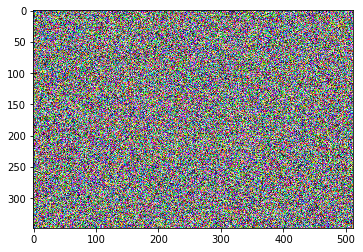

In [163]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)
x = rand_img(new_style_shape)
plt.imshow(x[0]);plt.show()

In [164]:
iterations = 10

In [165]:
x = solver(mul_total_eval_obj, iterations, x, new_style_shape, 'tiled')

Iteration : 0
 Loss at iteration 0 is : 124465.890625
Iteration : 1
 Loss at iteration 1 is : 87846.59375
Iteration : 2
 Loss at iteration 2 is : 78919.140625
Iteration : 3
 Loss at iteration 3 is : 74287.8828125
Iteration : 4
 Loss at iteration 4 is : 71588.8515625
Iteration : 5
 Loss at iteration 5 is : 69782.2109375
Iteration : 6
 Loss at iteration 6 is : 68456.984375
Iteration : 7
 Loss at iteration 7 is : 67440.03125
Iteration : 8
 Loss at iteration 8 is : 66580.0625
Iteration : 9
 Loss at iteration 9 is : 65872.46875


This was our final image which got generated when we had an untiled style image of a nintendo controller.

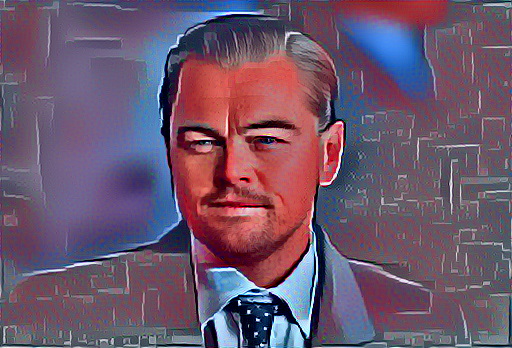

In [45]:
Image.open(RESULTS + 'res_at_iteration_untiled_14.png')

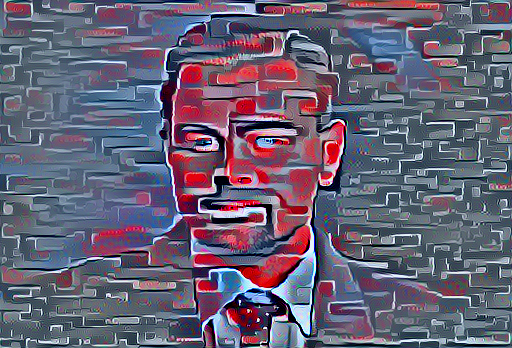

In [166]:
Image.open(RESULTS + 'res_at_iteration_tiled_9.png')

As we can see from the above two figures, in the untiled version, the texture of the controller is not so apparent. Whereas, when we look at the tiled version, we see that the 'boxiness' of the D-Pad is much more apparent.

Also, I havent found the proper combination of weights yet, but I do believe that with the ideal weights, we should be able to properly capture the texture of the buttons too!


In [168]:
def animate_untiled(i):
    fname = RESULTS + 'res_at_iteration_untiled_'+str(i)+'.png'
    ax.imshow(Image.open(fname))

In [169]:
anim = animation.FuncAnimation(fig, animate_untiled, frames = 10, interval = 200)
HTML(anim.to_html5_video())

In [170]:
def animate_tiled(i):
    fname = RESULTS + 'res_at_iteration_tiled_'+str(i)+'.png'
    ax.imshow(Image.open(fname))

In [171]:
anim = animation.FuncAnimation(fig, animate_tiled, frames = 10, interval = 200)
HTML(anim.to_html5_video())